In [44]:
# 2019-11-14
# A. Pendleton
# Expression line plots for gene list generated from sample filtration steps

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

#Plotting
import pandas as pd
import seaborn as sns
import fastcluster

The below geneList would be a python list of gene identifiers that was propagated following sample filtration steps such as: 
    - Search by gene ID(s)
    - Search by homolog ID(s)
    - Search by functional annotations
    - Filtration by expression thresholds and/or patterns from the drop-down expression lists

## Inputs

This plot requires the following information:

- $ROOT/Genes_expression.txt
- list of genes to plot that was populated using any of the steps outlined in above cell. 

#### Define root directory

In [4]:
rootDir = '/depot/jwisecav/data/pendlea/coexpression_assessments/development/coexp_development/'

#### Sample file

In [5]:
#Define the sample file
# File naming is static -- should always be the file name "samples.txt"
sampleFile = rootDir + 'samples.txt'

#### Global gene expression file

In [6]:
#Define expression file. 
# File naming is static -- should always be file name "Genes_expression.txt"
expFile = rootDir + 'Genes_expression.txt'


#### Gene list to plot

##### Practice gene list 

In [120]:
geneList = ["Sevir.1G000300","Sevir.1G001000","Sevir.1G001100","Sevir.1G001600","Sevir.1G001700","Sevir.1G001800","Sevir.1G001900","Sevir.1G002400","Sevir.1G002800","Sevir.1G002900","Sevir.1G003200","Sevir.1G003401","Sevir.1G003500","Sevir.1G003600","Sevir.1G004400","Sevir.1G004600","Sevir.1G004700","Sevir.1G004800","Sevir.1G005300","Sevir.1G005400","Sevir.1G005800","Sevir.1G007466","Sevir.1G007700","Sevir.1G007766","Sevir.1G007800","Sevir.1G008100","Sevir.1G008300","Sevir.1G008400","Sevir.1G008700","Sevir.1G008801","Sevir.1G009000","Sevir.1G010200","Sevir.1G011700","Sevir.1G012100","Sevir.1G012300","Sevir.1G012500","Sevir.1G012700","Sevir.1G012800","Sevir.1G013100","Sevir.1G013450"]
geneList = geneList[0:10]

print('%i genes in geneList' % len(geneList))     



10 genes in geneList


___________

### Store the sample information
##### Link the sample IDs to conditions and experiments

In [115]:
#Dictionary to store the sample information
# the dictionary should have the following structure:
#.      sampleDict[sampleID] = condition

sampleDict = {} 
conditionDict = {}
experiments = []

lineCount = 0# Track the line count while parsing sample file

for line in open(sampleFile, 'r'): #Parse each data file line
    line=line.rstrip().split('\t') #strip and split this tab-delimited file
    
    lineCount += 1 #add one to line count
    
    #Ignore header line
    if lineCount == 1:
        continue
    
    sampleID = line[0]
    condition = line[1] 
    experiment = line[2]
    
    sampleDict[sampleID] = [condition, experiment] #Track how samples are linked to conditions and experiments
    conditionDict[condition] = experiment
    experiments.append(experiment)
    
#Also append to experiments 
print('Stored sample-condition links for %i samples' % len(sampleDict.keys()))
print('    from %i conditions' % len(conditionDict.keys()))

experiments = np.unique(experiments)
print('    and %i experimental groups' % len(experiments))


Stored sample-condition links for 268 samples
    from 52 conditions
    and 7 experimental groups


___________

### Store gene expression data for genes in geneList

In [121]:

expDict = {}
samples = [] #Store the samples, in order defined by header line
conditions = []
sampleExpDict = {} #Store expression for ALL samples in one dictionary

lineCount = 0 #track line count

for line in open(expFile, 'r'):
    line=line.rstrip().split('\t') #split by tab -- is a tab-delimited file 
    lineCount += 1
    
    #Sample identifiers stored in header line. Will use samples as keys for expDict
    if lineCount == 1:
        for i in range(1,len(line)): #Sample names start at column 2 (index 1), column 1 == gene
            sampleID = line[i]
            samples.append(sampleID)
            
            #Determine condition based on the sample ID by searching sampleDict
            condition = sampleDict[sampleID][0]
            conditions.append(condition)
            
        print('%i samples stored in samples list' % len(samples))
        conditions = np.unique(conditions)
        print('    from %i conditions' % len(conditions))
        continue
        
    #Gene ID always in column 1
    geneID = line[0]
    
    #If the gene is not in the geneList list, continue
    if geneID not in geneList:
        continue
    
    #Start populating dictionary with the following structure
    #.    expDict[geneID][sampleID] = [[sampleID,expressionValue],[sampleID,expressionValue],[sampleID,expressionValue]...]
    expDict[geneID] = {}
    for condition in conditionDict.keys(): #Set up cleared lists to track expression levels per condition
        experiment = conditionDict[condition]
        if experiment not in expDict[geneID].keys():
            expDict[geneID][experiment] = {}
        expDict[geneID][experiment][condition] = []
    
    #Create empty key for samples in sampleExpDict
    sampleExpDict[geneID] = {}
    
    #Create new key per sampleID
    for sampleID in samples:
        #What column is the sample in samples?
        SampleColumnNumber = samples.index(sampleID)
        
        #What condition does this sample belong to?
        #Determine the condition the sample belongs to from sampleDict dictionary
        condition = sampleDict[sampleID][0]
        experiment = sampleDict[sampleID][1]
            
        #Now extract expression level from same column that matches the sample
        expressionValue = float(line[SampleColumnNumber+1])
        
        #Store in dictionary
        expDict[geneID][experiment][condition].append(expressionValue)

        #Populate dictionary to store the samples' expression
        sampleExpDict[geneID][sampleID] = expressionValue

print('Experimental expression values for %i genes stored' % len(expDict.keys()))


268 samples stored in samples list
    from 52 conditions
Experimental expression values for 10 genes stored


#### Calculate the average expression value, per gene, per condition

In [122]:
meanExpressionDict = {}

for geneID in expDict.keys():
    meanExpressionDict[geneID] = {} #Define the average dictionary for this gene
    
    for condition in conditionDict.keys():  
        experiment = conditionDict[condition] #get this condition's experimental group it belongs to
        #Create experiment key
        if experiment not in meanExpressionDict[geneID].keys():
            meanExpressionDict[geneID][experiment] = {}
            
        #Get the array of total expression values for this gene under the given condition
        allExpressionValues = expDict[geneID][experiment][condition]
        
        #Now calculate the mean, minimum, and maximum expression
        meanExpression = np.mean(allExpressionValues) 
        minExpression = min(allExpressionValues)
        maxExpression = max(allExpressionValues)
        
        meanExpressionDict[geneID][experiment][condition] = [meanExpression, minExpression, maxExpression] #store the expression value
print('Average expression levels stored for %i genes' % len(meanExpressionDict.keys()))   

Average expression levels stored for 10 genes


___________

## Line plot

Here, we will draw line plots that will show the expression levels per gene (with standard error bars) across all conditions. 

In [128]:
def get_plot_colors(geneList):
    NUM_COLORS = len(geneList) #how many colors our plot will have depends on how many genes
    
    #The number of line styles we need also depends on the number of genes we have
    # if we dont have a lot, we will only use solid lines. While more complexity is needed
    # as gene count increases, so we can distinguish each gene
    if NUM_COLORS < 20:
        LINE_STYLES=['solid']
    if NUM_COLORS >= 20 and NUM_COLORS < 40:
        LINE_STYLES = ['solid', 'dashed']
    if NUM_COLORS >= 40 and NUM_COLORS < 60:
        LINE_STYLES = ['solid', 'dashed', 'dashdot']
    if NUM_COLORS >= 60:
        LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
    NUM_STYLES = len(LINE_STYLES)

    #return the following plotting variables
    return NUM_COLORS, LINE_STYLES, NUM_STYLES

Experiment =  Cold
Experiment =  Drought
Experiment =  Happy Plants
Experiment =  Herbivory
Experiment =  Light
Experiment =  Methyl Jasmonate
Experiment =  Salt


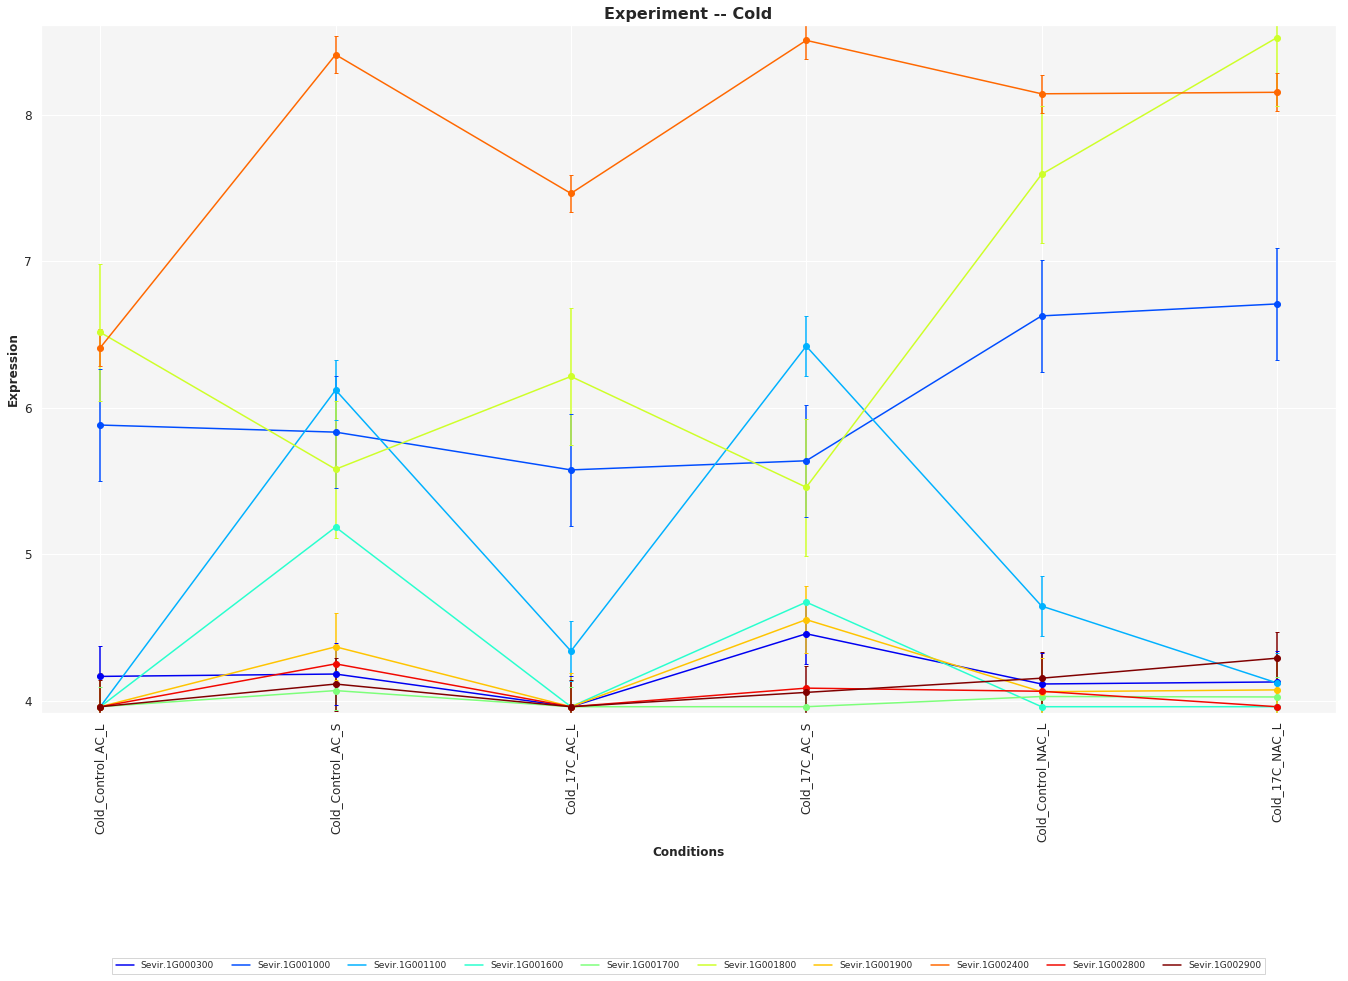

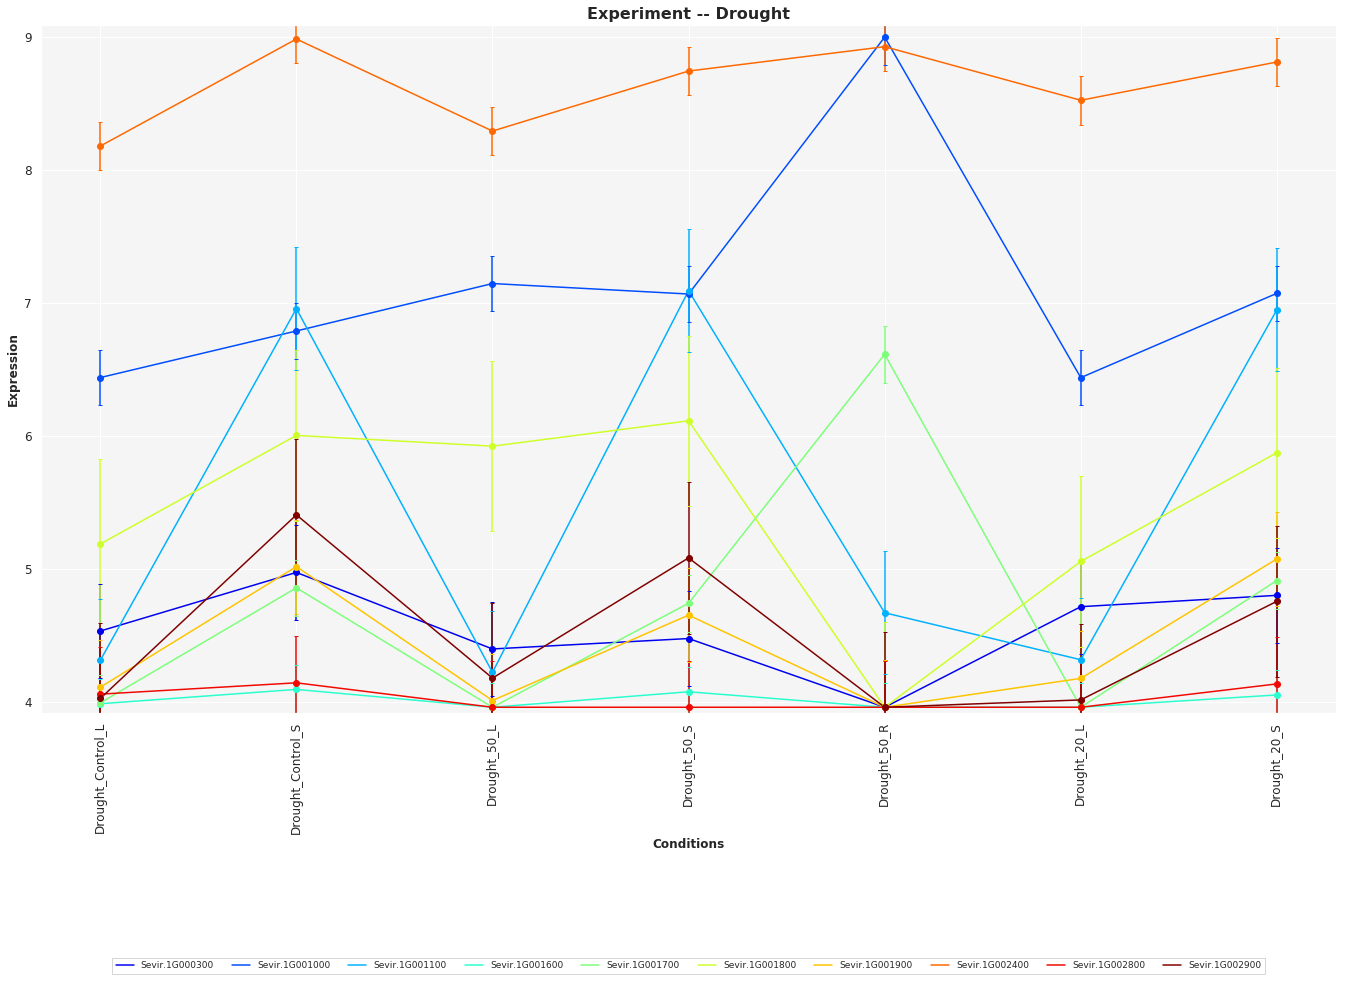

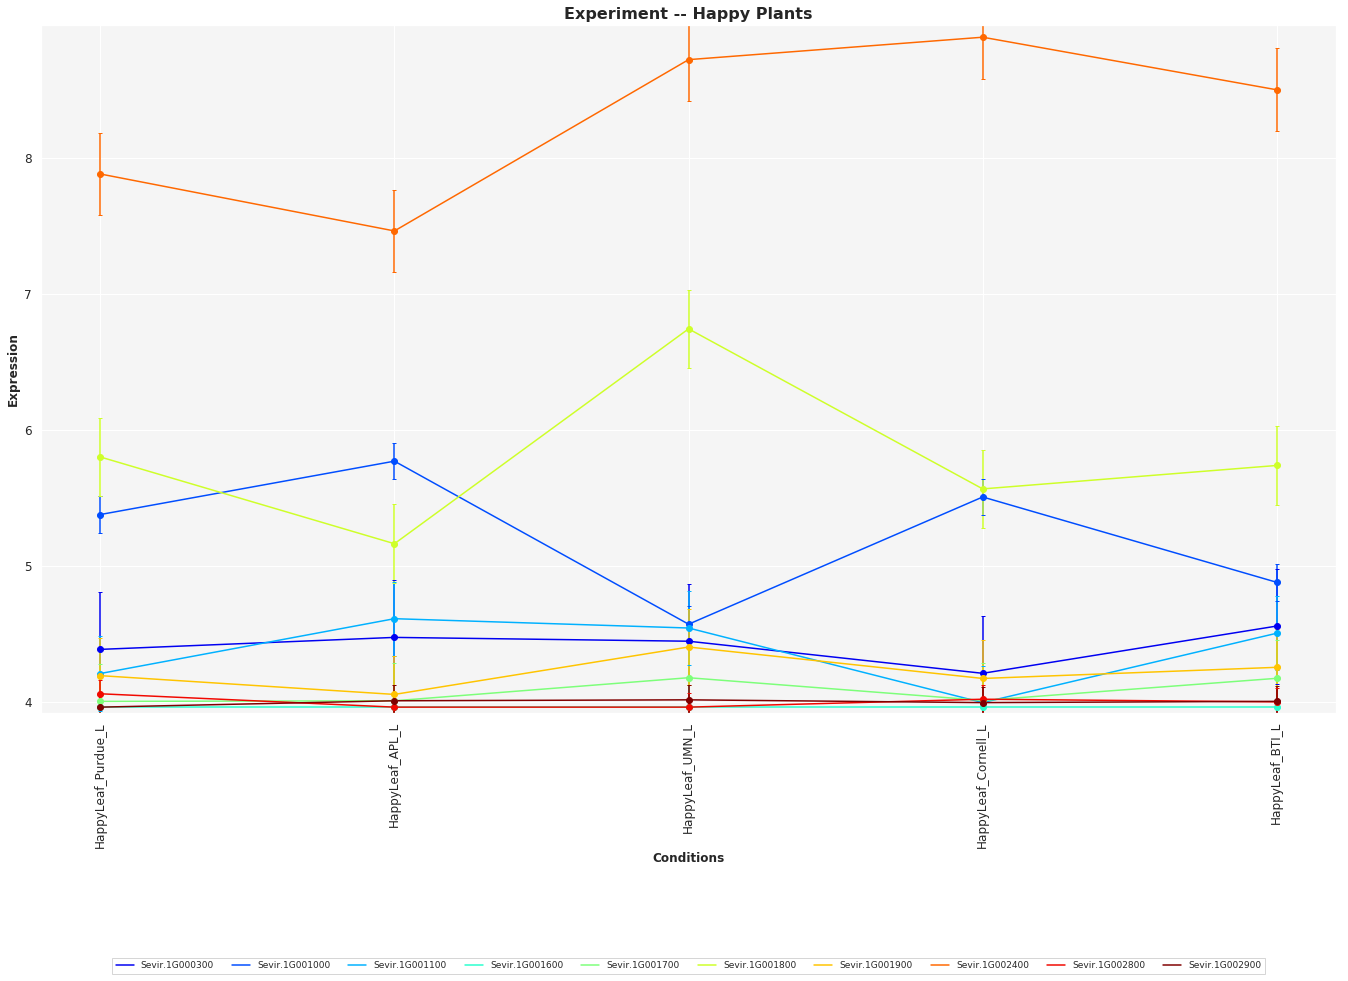

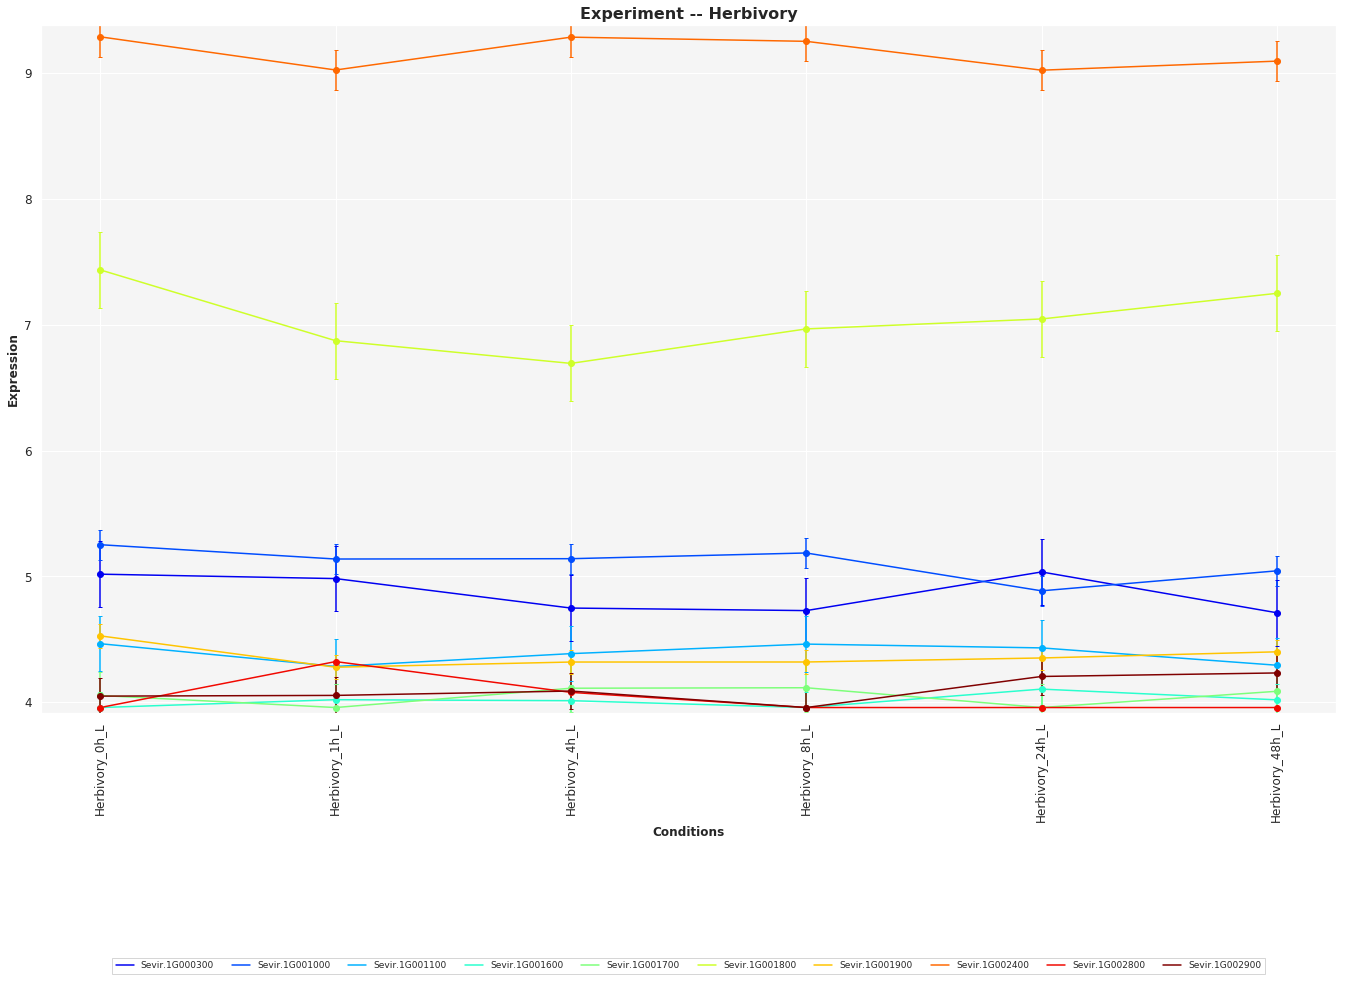

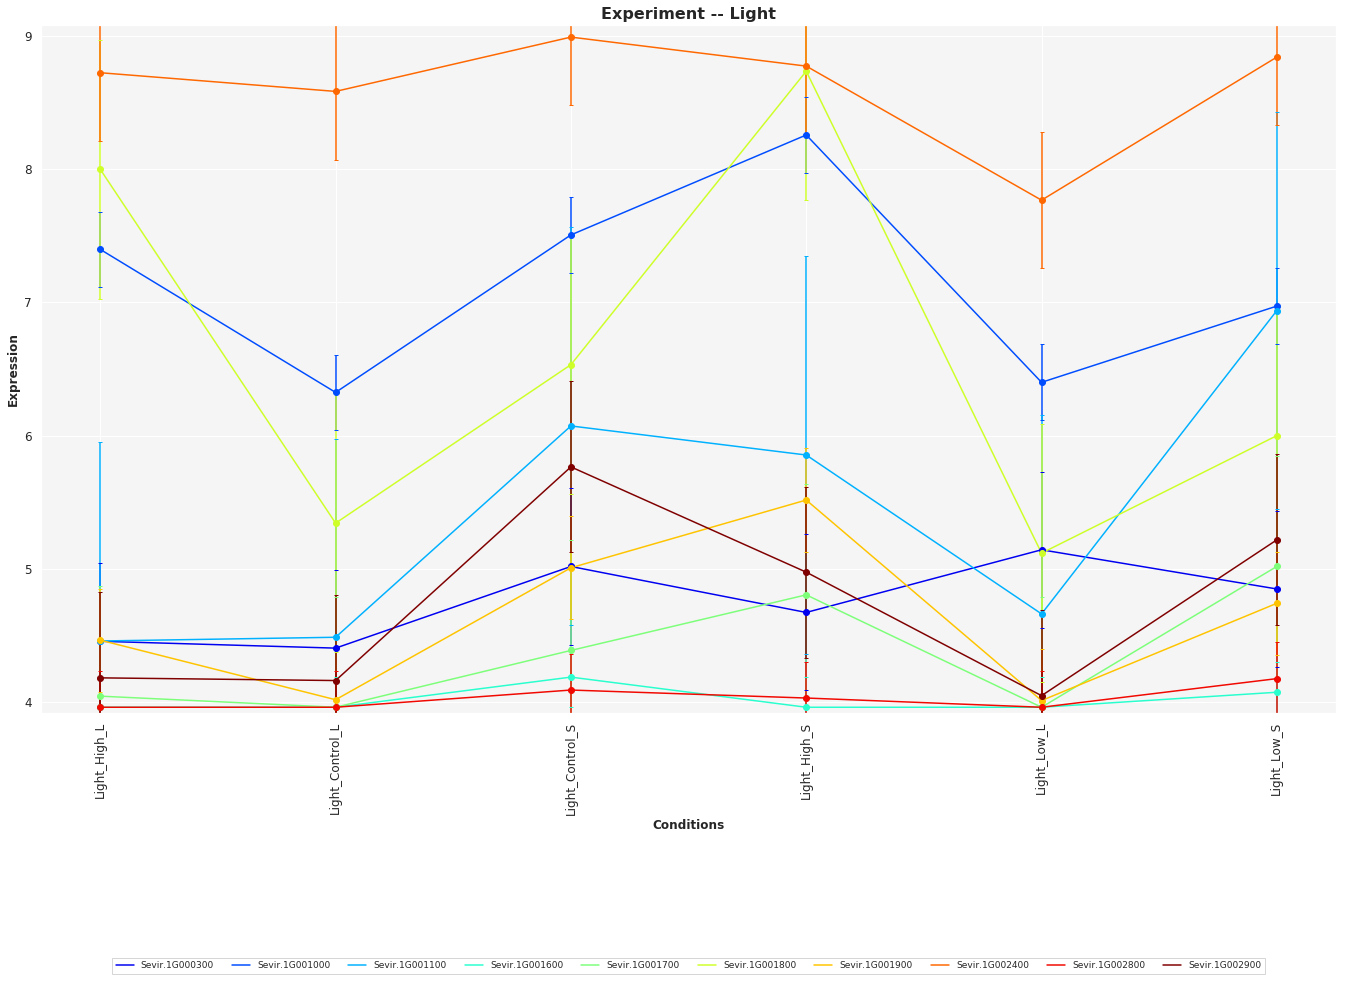

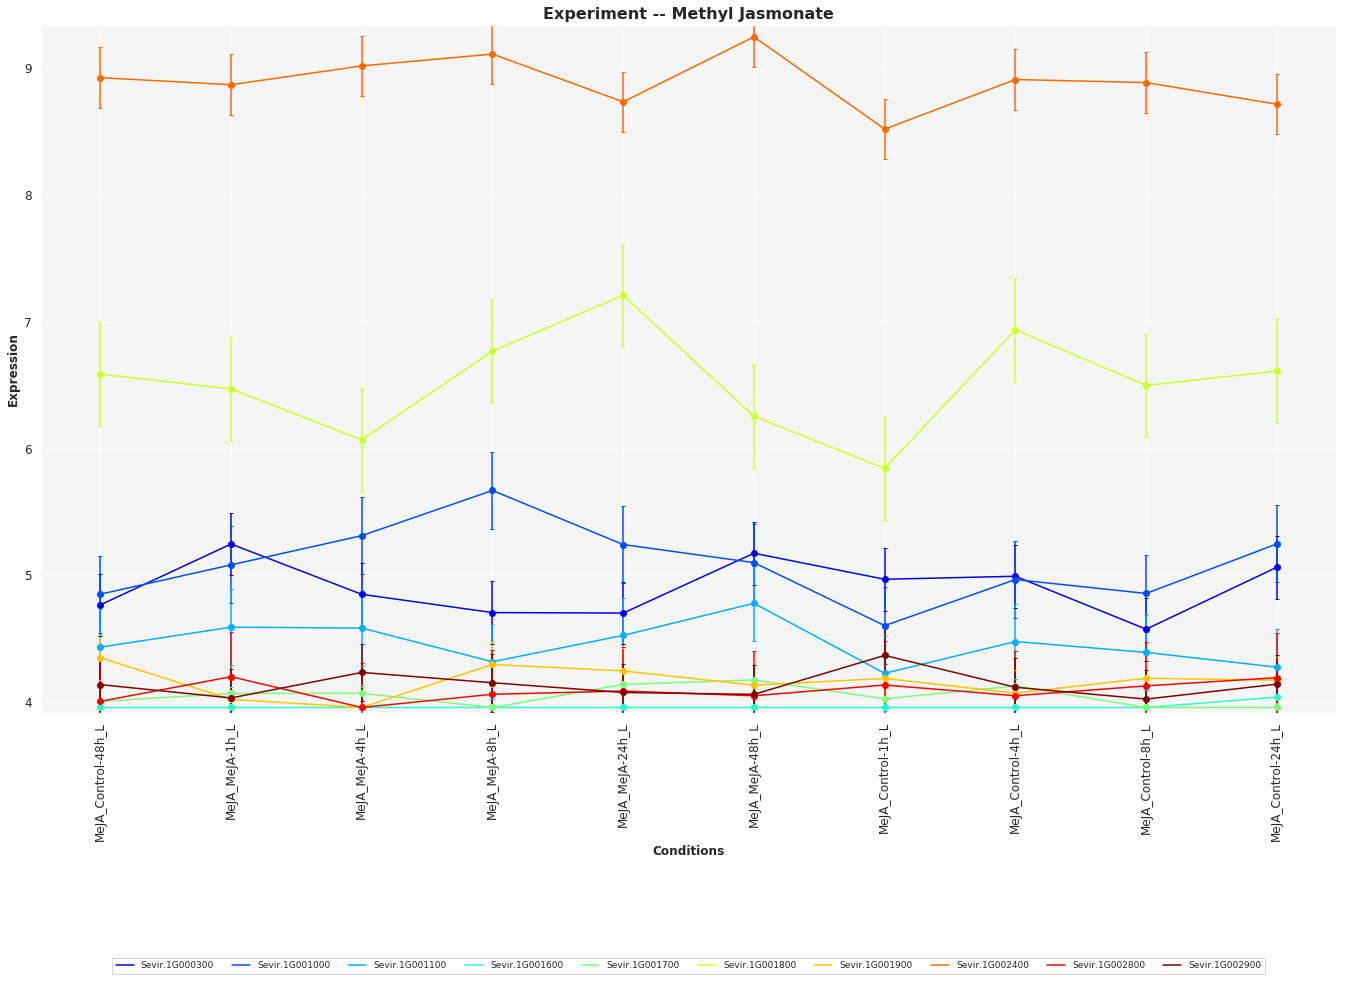

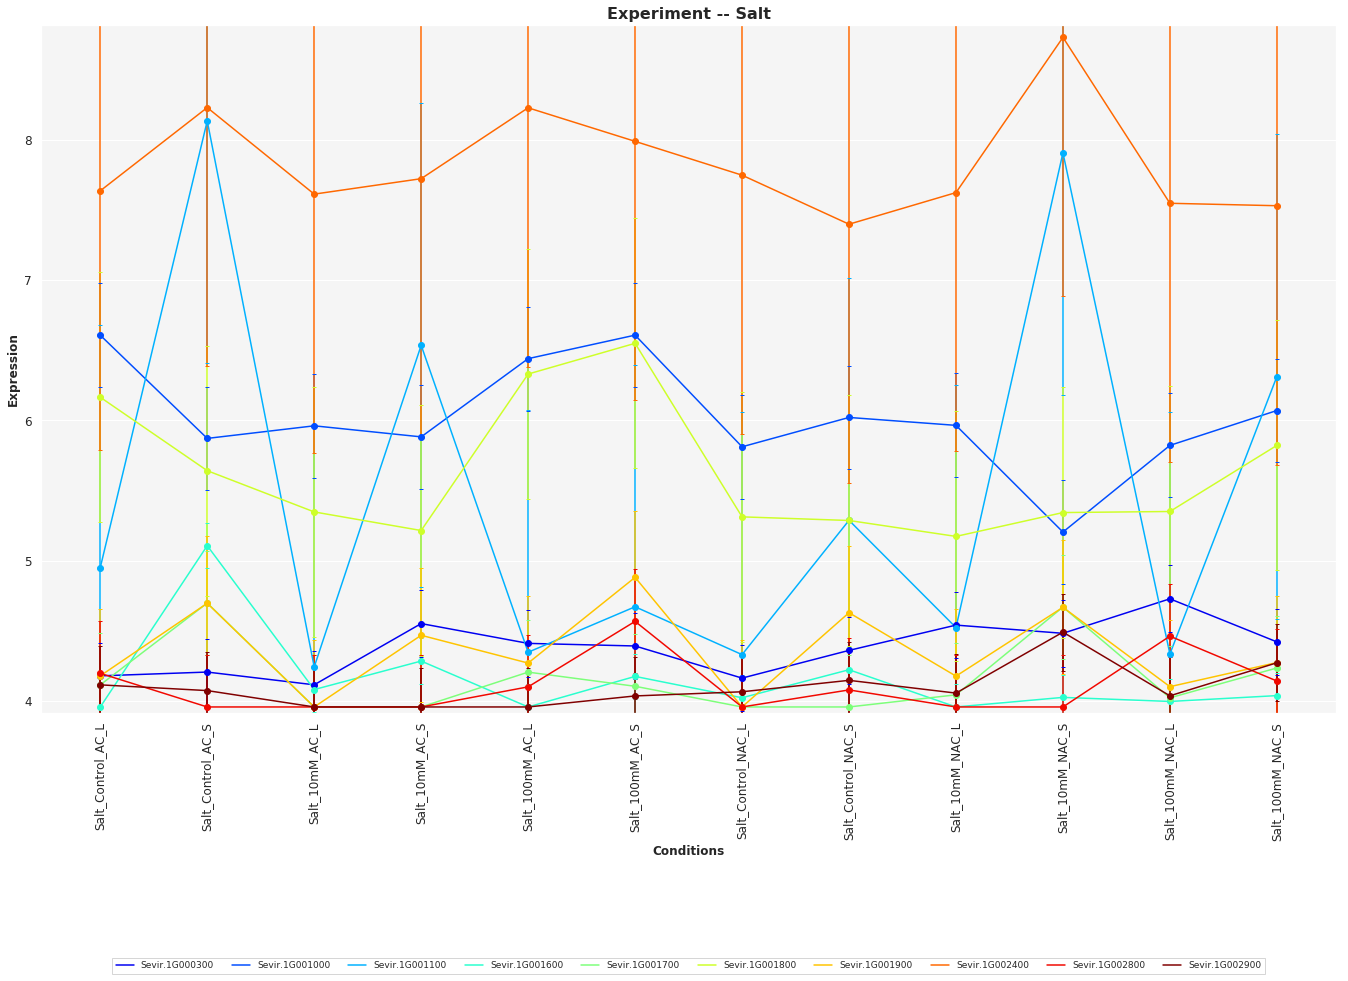

In [129]:
#Determine plotting color schema
NUM_COLORS, LINE_STYLES, NUM_STYLES = get_plot_colors(geneList)
cm = plt.get_cmap('jet')


for experiment in experiments:
    print('Experiment = ', experiment)
    
    plt.figure(figsize=(20,14)) # create empty figure
    ax = plt.subplot(111) #Define ax so we can put legend outside


    labels=[] #this is to store your conditions, if you want them visible along the x axis, the plt.legend will use this 
    
    geneCount = 0

    trackGlobalY = [] #Keep track of the max expression (yvalue) observed so we can dynanmically change y axis

    #this will draw the line for each gene as the loop goes on
    for geneID in geneList:
        geneCount+=1
        
        #Get the color based on how many genes have been processed so far
        COLOR = cm(geneCount/NUM_STYLES*float(NUM_STYLES)/NUM_COLORS)
        LINE_STYLE = LINE_STYLES[geneCount%NUM_STYLES]
        
        
        x, y = [], [] #Clear the x,y variables for plotting line

        #go through each condition, and then plot the average expression level for that condition
        index = 0
        for condition in meanExpressionDict[geneID][experiment].keys():
            index += 1
            
            x.append(condition) # Add the condition name so it willl show up on the x axis

            #Now you want to append the average expression value
            averageExpressionValue = float(meanExpressionDict[geneID][experiment][condition][0])
            y.append(averageExpressionValue)
            trackGlobalY.append(averageExpressionValue) #Track all y variables. This way you can find the maximum and dynamically change your y axis

            #Calculate the standard deviation of expression
            std = np.std(expDict[geneID][experiment][condition])

        #Line plots of average expression values
        ax.plot(x,y, color=COLOR, linestyle=LINE_STYLE, label=geneID)
        
        # Plotting the error bars only if there are a few genes. Lots of genes makes it super hard to see
        if len(geneList) < 20:
            ax.errorbar(x, y, yerr=std, fmt='o', ecolor=COLOR,
                    color=COLOR, capsize=2)
        
        #If more than 99 genes have been processed, then quit... we can't display more than that
        if geneCount > 99:
            break
            
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    #Final plot information below once loop is done
    yMin = 3.75
    plt.ylim(min(trackGlobalY)-.01*min(trackGlobalY), max(trackGlobalY)+.01*max(trackGlobalY)) #dynamically calculate y limits based on the maximum y value seen in dataset
    plt.ylabel('Expression', fontweight='bold', fontsize=12) #label y axis
    plt.xlabel('Conditions', fontweight='bold', fontsize=12) #label x axis
    plt.xticks(rotation=90, fontsize=12) #rotate your x axis labels, set x tick font size
    plt.yticks(fontsize=12) #set y tick font size
    plt.title('Experiment -- %s' % experiment, fontweight='bold', fontsize=16) #Add title detailing experimental group
    ax.grid(True) 
    ax.set_facecolor('whitesmoke')
    ## Put a legend to the right of the current axis
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=False, shadow=False, ncol=10, fontsize=9, facecolor="white")
    

    plt.tight_layout()





# Draw heatmaps

In [131]:
# Add "ALL" to experiments array so that we can plot all experiments
Experiments = []
Experiments.append('All')

for e in experiments:
    Experiments.append(e)

print(Experiments)


['All', 'Cold', 'Drought', 'Happy Plants', 'Herbivory', 'Light', 'Methyl Jasmonate', 'Salt']


In [132]:
##########################################################################################     
def draw_expression_heatmap(experimentExpressionDict, geneList):
    
    ###############################################################
    #Store the expression data in a pandas dataframe for plotting
    df = pd.DataFrame(experimentExpressionDict)
    #Make all columns have float data so they can be plotted
    df[df.columns] = df[df.columns].astype(float)
    #Transpose for viewing
    df = df.transpose()
    ###############################################################
    df.head()
    #Draw clustered heat map
    sns.set(font_scale=0.2)
    sns_plot = sns.clustermap(df,figsize=(11, 12),xticklabels=1)
    if len(expDict.keys()) < 50:
        if len(expDict.keys()) > 10:
            fontSize = 6
        if len(expDict.keys()) <= 10:
            fontSize = 12
        plt.setp(sns_plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize = fontSize)

    #Bold the yaxis labels if it matches of gene of interest
    for geneID in geneList:
        for i,t in enumerate(sns_plot.ax_heatmap.yaxis.get_majorticklabels()):
            if geneID in t.get_text():
                t.set_weight("bold")
        

All


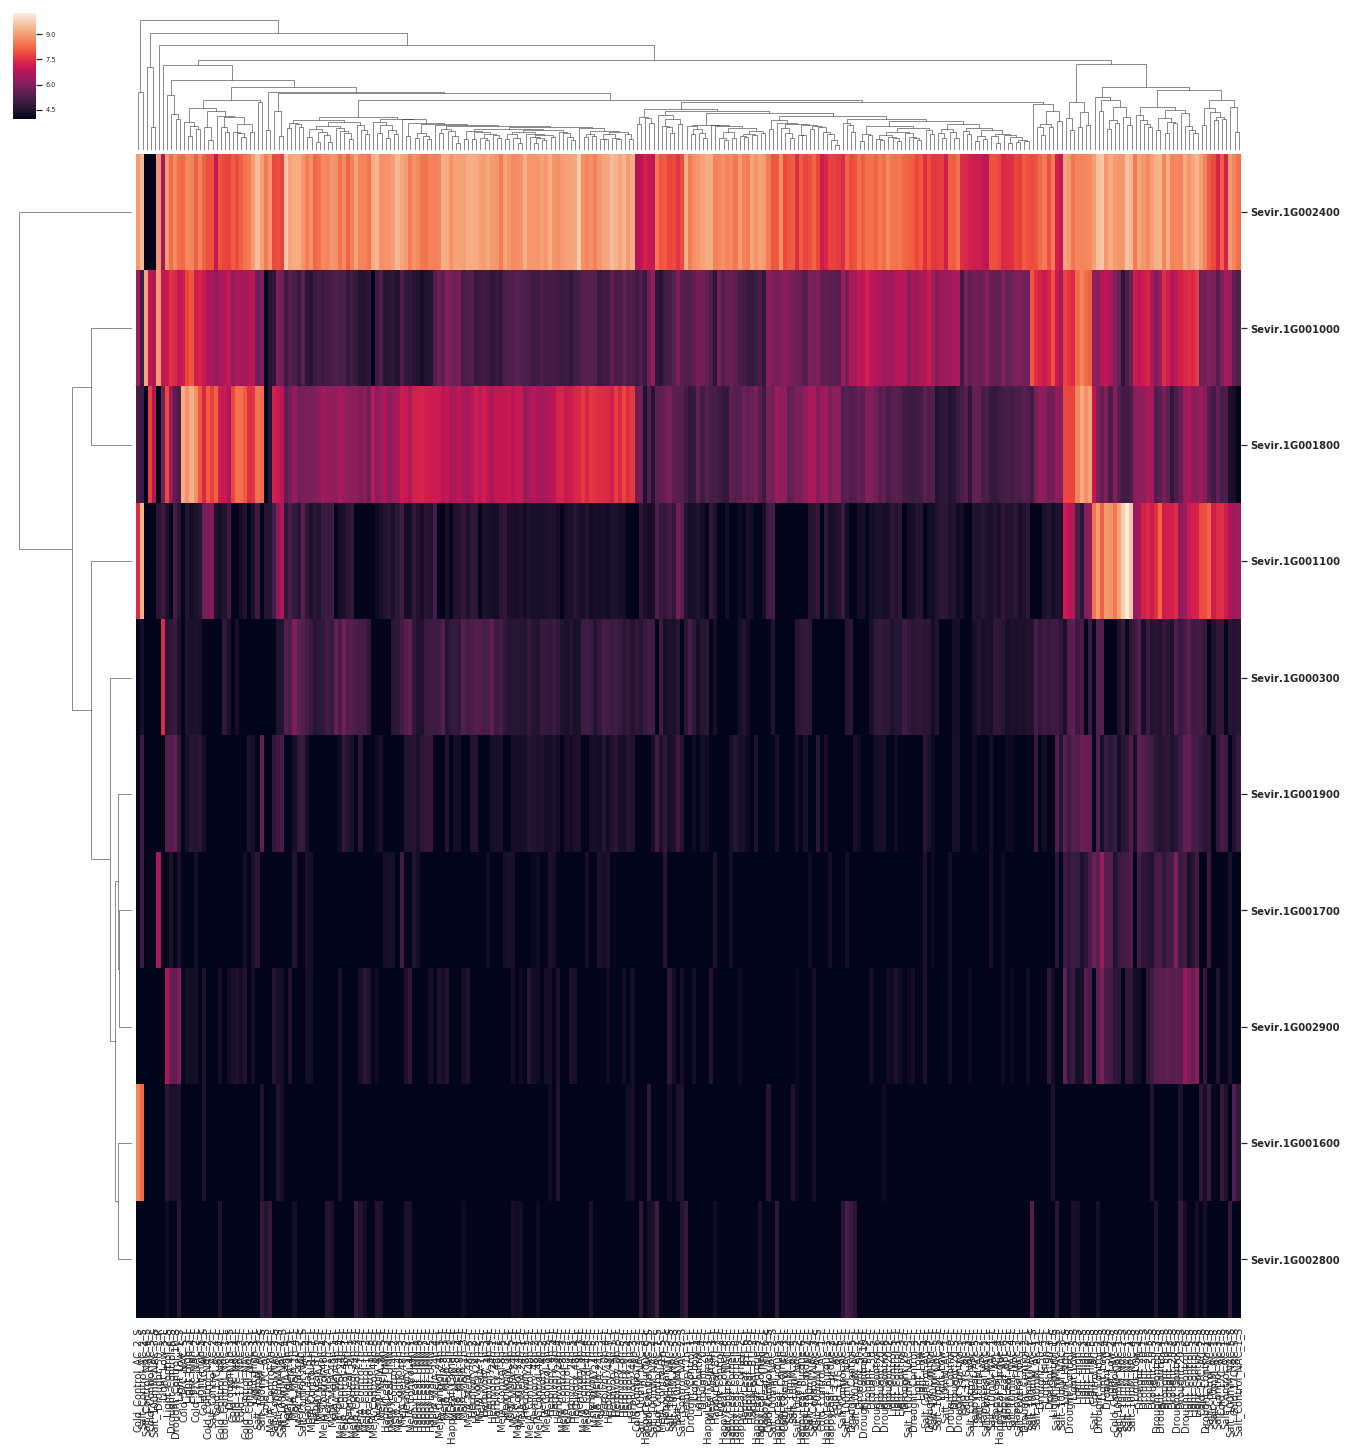

In [133]:

for experiment in Experiments: 
    print(experiment)
    
    experimentExpressionDict = {}
    
    for geneID in geneList:
        count+=1
        
        #Create empty key in dictionary for this gene
        experimentExpressionDict[geneID] = {}

        x, y = [], [] #Clear the x,y variables for plotting line

        #go through each condition, and then plot the average expression level for that condition
        index = 0
        
        #If you're wanting to plot ALL conditions/experiments in one heatmap:
        if experiment == 'All':
            for sampleID in sampleDict.keys():
                experimentExpressionDict[geneID][sampleID] = sampleExpDict[geneID][sampleID]
        
        
        #If you want to make a heatmap just for one experiment
        else:
            for sampleID in sampleExpDict[geneID].keys():
                EXPERIMENT = sampleDict[sampleID][1]
                #If the experiment this sample belongs to does not match the experiment we wish to plot then skip
                if EXPERIMENT != experiment:
                    continue
                else:
                    experimentExpressionDict[geneID][sampleID] = sampleExpDict[geneID][sampleID]
                
    ###############################################################
    #Store the expression data in a pandas dataframe for plotting
    df = pd.DataFrame(experimentExpressionDict)
    #Make all columns have float data so they can be plotted
    df[df.columns] = df[df.columns].astype(float)
    #Transpose for viewing
    df = df.transpose()
    ###############################################################

    #Draw clustered heat map
    sns.set(font_scale=0.6)
    sns_plot = sns.clustermap(df,figsize=(22, 24),xticklabels=1)
    """if len(experimentExpressionDict.keys()) < 50:
        if len(experimentExpressionDict.keys()) > 10:
            fontSize = 8
        if len(experimentExpressionDict.keys()) <= 10:
            fontSize = 12
    else:
        fontSize=6"""
    plt.setp(sns_plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize = fontSize)
    sns_plot.ax_heatmap.set_xticklabels(sns_plot.ax_heatmap.get_xmajorticklabels(), rotation=90, fontsize = 10)


    #Bold the yaxis labels if it matches of gene of interest
    sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_ymajorticklabels(), rotation=0,fontsize = 10)
    for geneID in geneList:
        for i,t in enumerate(sns_plot.ax_heatmap.yaxis.get_majorticklabels()):
            if geneID in t.get_text():
                t.set_weight("bold")        
    ax.legend(fontsize='x-large')
    #draw_expression_heatmap(experimentExpressionDict, geneList)
    break
    